In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal

In [2]:
DATA_DIR = Path("./CWRU/12k_drive_end_fault_subset_labeled") 
OUT_DIR  = Path("./bw_out_notebook") 

FS = 12000.0               
CHANNEL = "DE"             
NPERSEG = 4096             
PROM_DB = 6.0              
MAX_PEAKS = 5              
FMIN = 10.0                
FMAX = None                
PLOT_XLIM = (0, 2000)      

MAX_FILES_TO_PLOT = None

In [3]:
def load_cwru_mat(mat_path: str | Path):
    mat_path = Path(mat_path)
    md = loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    keys = [k for k in md.keys() if not k.startswith("__")]

    def pick_suffix(suffix: str):
        for k in keys:
            if k.endswith(suffix):
                return k, md[k]
        return None, None

    k_de, de = pick_suffix("_DE_time")
    k_fe, fe = pick_suffix("_FE_time")
    k_rpm, rpm = pick_suffix("RPM")

    def to_1d(x):
        if x is None:
            return None
        x = np.asarray(x).reshape(-1)
        return x.astype(np.float64)

    return {
        "path": str(mat_path),
        "de_key": k_de,
        "fe_key": k_fe,
        "rpm_key": k_rpm,
        "DE": to_1d(de),
        "FE": to_1d(fe),
        "RPM": float(rpm) if rpm is not None else None,
        "keys": keys,
    }

def label_from_filename(stem: str):
    s = stem.upper()
    s = s.split("__", 1)[0]
    if "NORMAL" in s or "BASELINE" in s:
        return "normal"
    if s.startswith("IR"):
        return "inner_race"
    if s.startswith("OR"):
        return "outer_race"
    if s.startswith("B") or "BALL" in s:
        return "ball"
    return "unknown"

def load_folder(folder: str | Path):
    folder = Path(folder)
    mats = sorted(folder.glob("*.mat"))
    items = []
    for p in mats:
        d = load_cwru_mat(p)
        d["label"] = label_from_filename(p.stem)
        items.append(d)
    return items

In [4]:
assert DATA_DIR.exists(), f"DATA_DIR not found: {DATA_DIR.resolve()}"

data = load_folder(DATA_DIR)
print("loaded:", len(data))
print("example:", data[0]["path"], "DE_len=", None if data[0]["DE"] is None else len(data[0]["DE"]),
      "RPM=", data[0]["RPM"], "label=", data[0]["label"])

loaded: 3
example: CWRU/12k_drive_end_fault_subset_labeled/B007_0__118.mat DE_len= 122571 RPM= 1796.0 label= ball


In [5]:
def preprocess(x: np.ndarray, detrend=True, normalize=True):
    x = np.asarray(x, dtype=np.float64)
    if detrend:
        x = signal.detrend(x, type="constant")
    if normalize:
        std = x.std() + 1e-12
        x = x / std
    return x

def welch_psd(x: np.ndarray, fs: float, nperseg: int = 4096, noverlap: int | None = None):
    if noverlap is None:
        noverlap = nperseg // 2
    f, Pxx = signal.welch(
        x, fs=fs, window="hann", nperseg=nperseg, noverlap=noverlap,
        detrend=False, scaling="density"
    )
    return f, Pxx

In [ ]:
def _interp_crossing(f1, y1, f2, y2, y_target):
    if y2 == y1:
        return 0.5 * (f1 + f2)
    t = (y_target - y1) / (y2 - y1)
    return f1 + t * (f2 - f1)

def half_power_bandwidth(freq: np.ndarray, psd: np.ndarray, peak_idx: int):
    P0 = psd[peak_idx]
    thr = P0 / 2.0
    n = len(psd)

    i = peak_idx
    while i > 0 and psd[i] >= thr:
        i -= 1
    if i == 0:
        return None
    f_left = _interp_crossing(freq[i], psd[i], freq[i+1], psd[i+1], thr)

    j = peak_idx
    while j < n - 1 and psd[j] >= thr:
        j += 1
    if j == n - 1:
        return None
    f_right = _interp_crossing(freq[j-1], psd[j-1], freq[j], psd[j], thr)

    if f_right <= f_left:
        return None

    bw = f_right - f_left
    f0 = freq[peak_idx]
    Q = f0 / (bw + 1e-12)
    zeta = bw / (2.0 * f0 + 1e-12)

    return {
        "f0": float(f0),
        "P0": float(P0),
        "f_left": float(f_left),
        "f_right": float(f_right),
        "bandwidth": float(bw),
        "Q": float(Q),
        "zeta_est": float(zeta),
        "thr_half_power": float(thr),
    }

In [7]:
def find_psd_peaks(freq, psd, fmin=10.0, fmax=None, prominence_db=6.0, max_peaks=5):
    eps = 1e-20
    psd_db = 10.0 * np.log10(psd + eps)

    mask = freq >= fmin
    if fmax is not None:
        mask &= (freq <= fmax)

    idx = np.where(mask)[0]
    if len(idx) < 10:
        return np.array([], dtype=int)

    pks, props = signal.find_peaks(psd_db[idx], prominence=prominence_db)
    peak_idx = idx[pks]

    if len(peak_idx) > max_peaks:
        order = np.argsort(psd_db[peak_idx])[::-1]
        peak_idx = peak_idx[order[:max_peaks]]

    return np.sort(peak_idx)

def analyze_one_item(item: dict, fs: float, channel="DE",
                     nperseg=4096, prom_db=6.0, max_peaks=5,
                     fmin=10.0, fmax=None):

    x = item.get(channel, None)
    if x is None or len(x) < nperseg:
        return None

    x = preprocess(x, detrend=True, normalize=True)
    freq, psd = welch_psd(x, fs=fs, nperseg=nperseg)

    peak_idx = find_psd_peaks(freq, psd, fmin=fmin, fmax=fmax,
                              prominence_db=prom_db, max_peaks=max_peaks)

    rows = []
    for rank, pidx in enumerate(peak_idx):
        bw = half_power_bandwidth(freq, psd, int(pidx))
        if bw is None:
            continue
        rows.append({
            "file": item.get("path", ""),
            "label": item.get("label", "unknown"),
            "rpm": item.get("RPM", None),
            "channel": channel,
            "peak_rank": rank,
            **bw
        })

    return freq, psd, rows

In [8]:
def plot_psd_with_bandwidth(freq, psd, bw_rows, title, xlim=None, max_labels=None):
    eps = 1e-20
    psd_db = 10 * np.log10(psd + eps)

    fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)
    ax.plot(freq, psd_db)
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("PSD [dB/Hz]")
    ax.set_title(title)

    bw_rows_sorted = sorted(bw_rows, key=lambda r: r["f0"])
    if max_labels is not None:
        bw_rows_sorted = bw_rows_sorted[:max_labels]

    for k, r in enumerate(bw_rows_sorted):
        f0, fl, fr = r["f0"], r["f_left"], r["f_right"]
        thr_db = 10 * np.log10(r["thr_half_power"] + eps)

        ax.axvline(f0, linestyle="--")
        ax.axvspan(fl, fr, alpha=0.15)
        ax.hlines(thr_db, fl, fr, linestyles=":")

        y0 = np.interp(f0, freq, psd_db)

        sign = 1 if (k % 2 == 0) else -1
        dy_pts = sign * (25 + 15 * (k // 2))     
        dx_pts = (40 + 10 * (k // 2)) * (1 if (k % 2 == 0) else -1) 

        label = f"Δf={r['bandwidth']:.2f}Hz\nQ={r['Q']:.2f}\nζ≈{r['zeta_est']:.4f}"

        ax.annotate(
            label,
            xy=(f0, y0),
            xytext=(dx_pts, dy_pts),
            textcoords="offset points",
            arrowprops=dict(arrowstyle="->", lw=0.8),
            ha="left" if dx_pts > 0 else "right",
            va="bottom" if dy_pts > 0 else "top",
            fontsize=7,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, ec="none"),
            clip_on=False,
        )

    if xlim is not None:
        ax.set_xlim(*xlim)

    plt.show()

In [ ]:
def plot_time_with_rms_peak(x, fs, title="", win_sec=1.0, t0=0.0, max_points=20000):
    x = np.asarray(x, dtype=np.float64)
    n = len(x)
    t = np.arange(n) / fs

    i0 = int(t0 * fs)
    i1 = min(n, i0 + max_points)
    xw = x[i0:i1]
    tw = t[i0:i1]

    rms = np.sqrt(np.mean(xw**2))
    peak_idx = np.argmax(np.abs(xw))
    peak_val = xw[peak_idx]
    peak_t = tw[peak_idx]

    fig, ax = plt.subplots(figsize=(12, 3.8), constrained_layout=True)
    ax.plot(tw, xw, lw=1.0)
    ax.set_title(title)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude")

    ax.axhline(+rms, linestyle="--")
    ax.axhline(-rms, linestyle="--")
    ax.text(tw[0], rms, f"  +RMS={rms:.3g}", va="bottom")
    ax.text(tw[0], -rms, f"  -RMS={rms:.3g}", va="top")

    ax.plot([peak_t], [peak_val], marker="o")
    ax.annotate(
        f"Peak={peak_val:.3g}\nCF={abs(peak_val)/(rms+1e-12):.2f}",
        xy=(peak_t, peak_val),
        xytext=(30, 30),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", lw=0.8),
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, ec="none"),
        fontsize=8
    )

    plt.show()

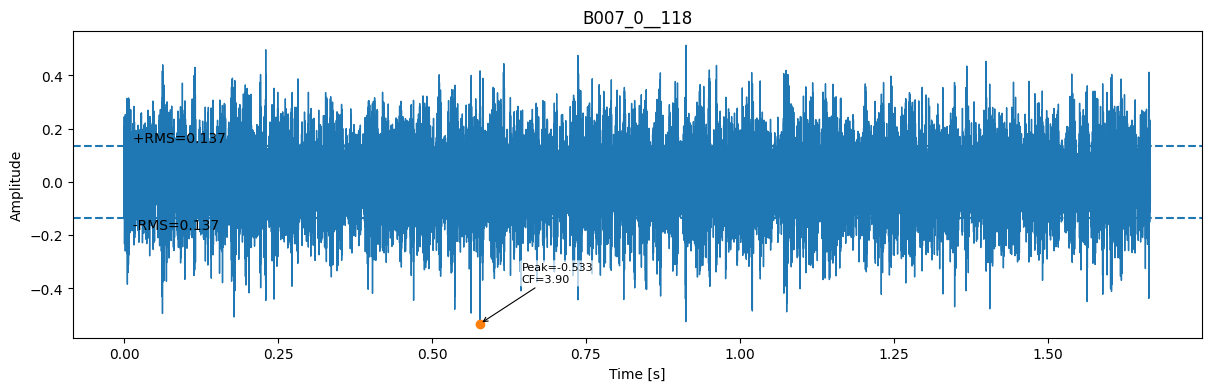

In [12]:
item = data[0]
x_raw = signal.detrend(item["DE"], type="constant") 
plot_time_with_rms_peak(x_raw, FS, title=Path(item["path"]).stem, t0=0.0)

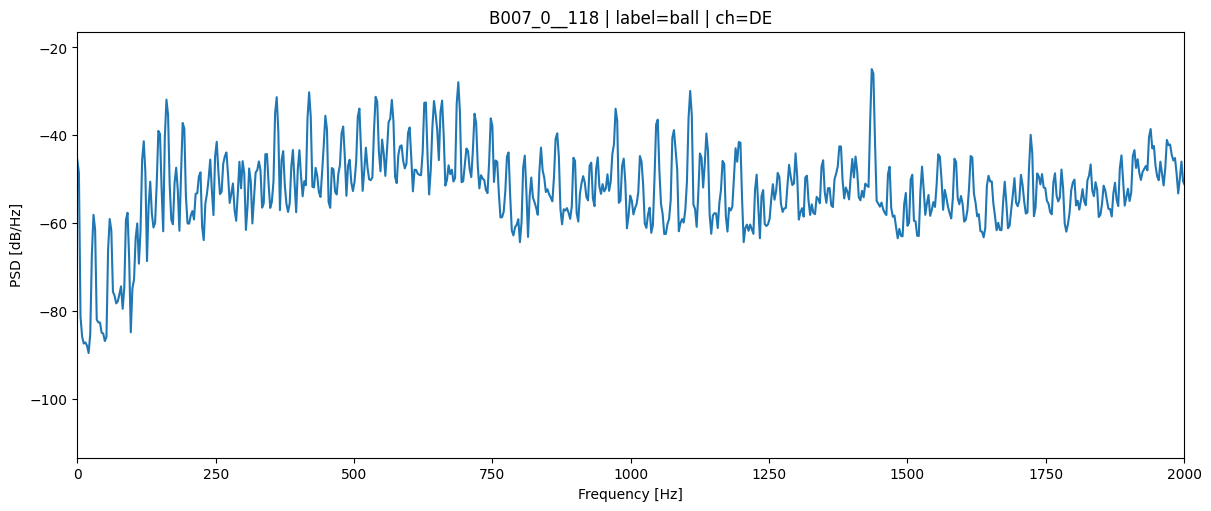

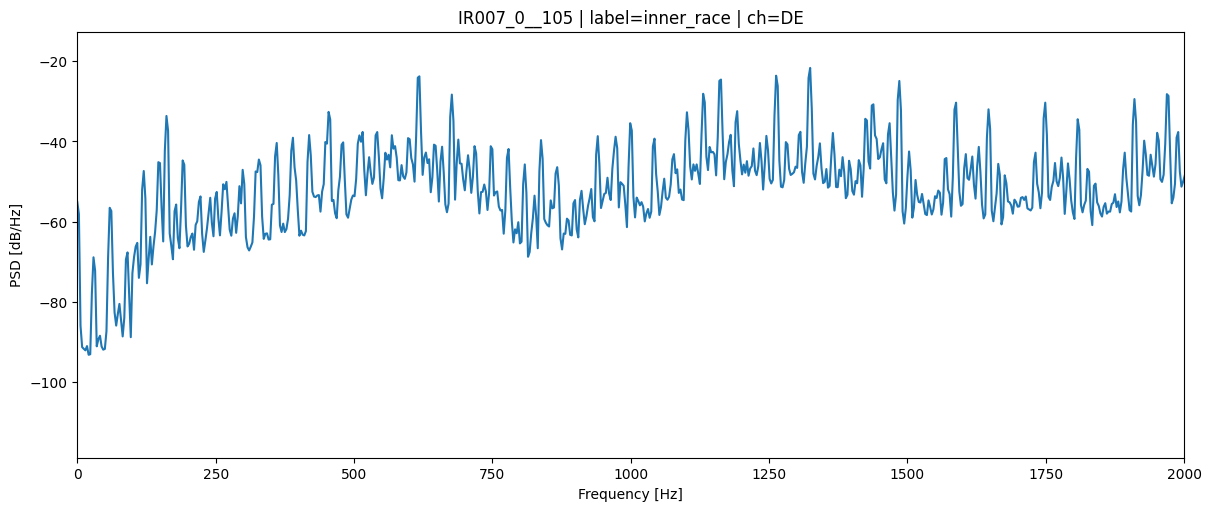

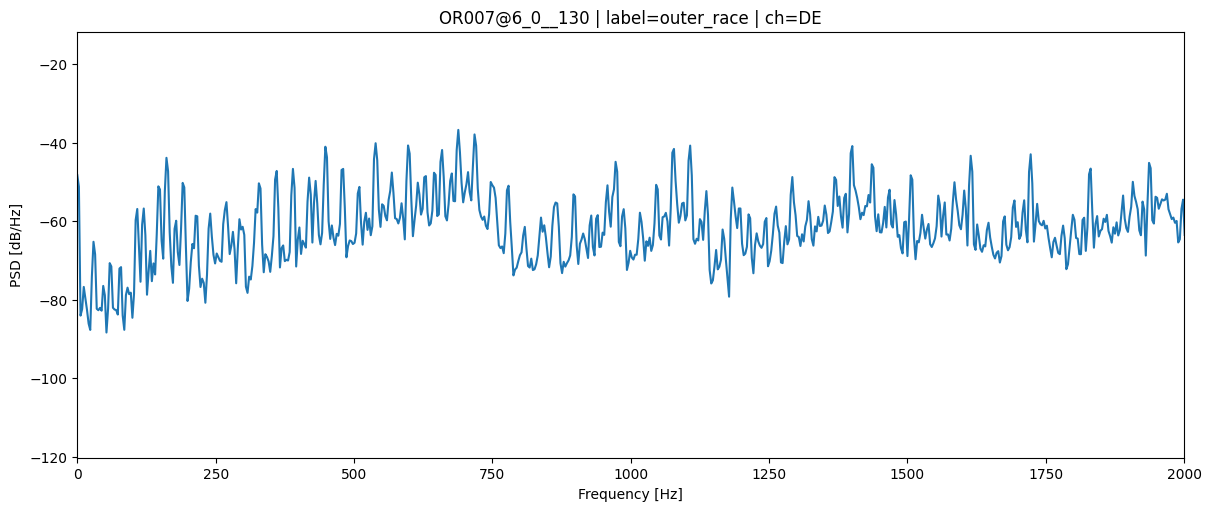

Done.
rows: 15
saved: bw_out_notebook/bandwidth_summary.csv


,file,label,rpm,channel,peak_rank,f0,P0,f_left,f_right,bandwidth,Q,zeta_est,thr_half_power
0,CWRU/12k_drive_end_fault_subset_labeled/B007_0...,ball,1796.0,DE,0,3231.445312,0.007527,3228.862326,3234.017019,5.154693,626.893828,0.000798,0.003764
1,CWRU/12k_drive_end_fault_subset_labeled/B007_0...,ball,1796.0,DE,1,3263.671875,0.007725,3259.828608,3265.693558,5.864950,556.470540,0.000899,0.003862
2,CWRU/12k_drive_end_fault_subset_labeled/B007_0...,ball,1796.0,DE,2,3278.320312,0.005480,3275.885361,3280.764665,4.879304,671.882811,0.000744,0.002740
3,CWRU/12k_drive_end_fault_subset_labeled/B007_0...,ball,1796.0,DE,3,3366.210938,0.006125,3361.461077,3368.844957,7.383880,455.886494,0.001097,0.003062
4,CWRU/12k_drive_end_fault_subset_labeled/B007_0...,ball,1796.0,DE,4,3445.312500,0.008238,3443.502158,3448.530629,5.028470,685.161131,0.000730,0.004119


In [9]:
OUT_DIR.mkdir(parents=True, exist_ok=True)
PER_FILE_DIR = OUT_DIR / "per_file_psd"
PER_FILE_DIR.mkdir(parents=True, exist_ok=True)

all_rows = []
n_plot = 0

for i, item in enumerate(data):
    ret = analyze_one_item(
        item,
        fs=FS,
        channel=CHANNEL,
        nperseg=NPERSEG,
        prom_db=PROM_DB,
        max_peaks=MAX_PEAKS,
        fmin=FMIN,
        fmax=FMAX,
    )
    if ret is None:
        continue

    freq, psd, rows = ret
    if len(rows) == 0:
        continue

    all_rows.extend(rows)

    if (MAX_FILES_TO_PLOT is None) or (n_plot < MAX_FILES_TO_PLOT):
        p = Path(item["path"])
        title = f"{p.stem} | label={item.get('label')} | ch={CHANNEL}"
        plot_psd_with_bandwidth(freq, psd, rows, title, xlim=PLOT_XLIM)

        out_png = PER_FILE_DIR / f"{p.stem}_psd_bw.png"
        eps = 1e-20
        psd_db = 10 * np.log10(psd + eps)

        plt.figure(figsize=(20, 5))
        plt.plot(freq, psd_db)
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("PSD [dB/Hz]")
        plt.title(title)

        for r in rows:
            f0, fl, fr = r["f0"], r["f_left"], r["f_right"]
            thr_db = 10 * np.log10(r["thr_half_power"] + eps)
            plt.axvline(f0, linestyle="--")
            plt.axvspan(fl, fr, alpha=0.15)
            plt.hlines(thr_db, fl, fr, linestyles=":")
        if PLOT_XLIM is not None:
            plt.xlim(*PLOT_XLIM)
        plt.tight_layout()
        plt.savefig(out_png, dpi=150)
        plt.close()

        n_plot += 1

df = pd.DataFrame(all_rows)
csv_path = OUT_DIR / "bandwidth_summary.csv"
df.to_csv(csv_path, index=False)

print("Done.")
print("rows:", len(df))
print("saved:", csv_path)
df.head()

/tmp/ipykernel_1304256/1305798265.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


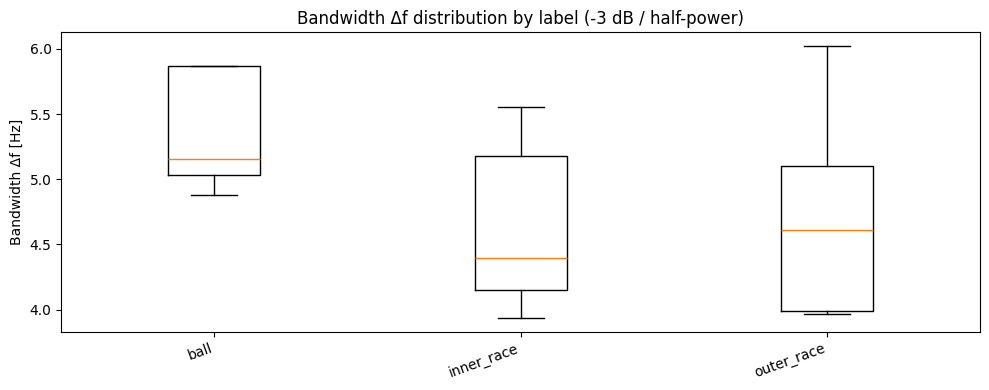

/tmp/ipykernel_1304256/1305798265.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


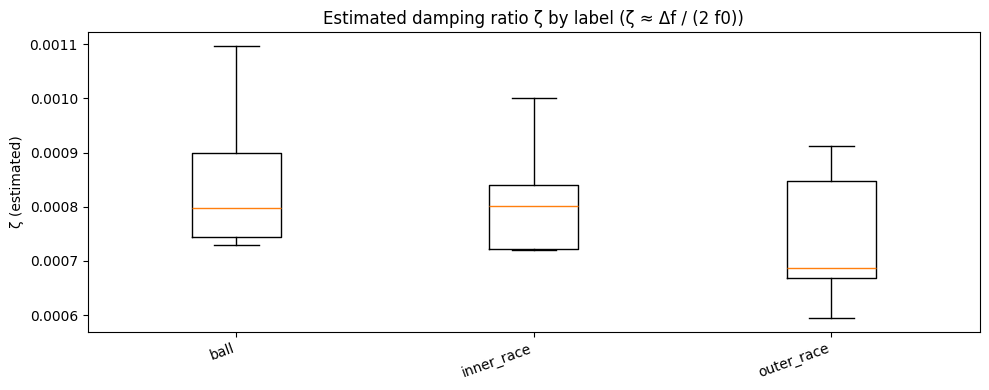

/tmp/ipykernel_1304256/1305798265.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


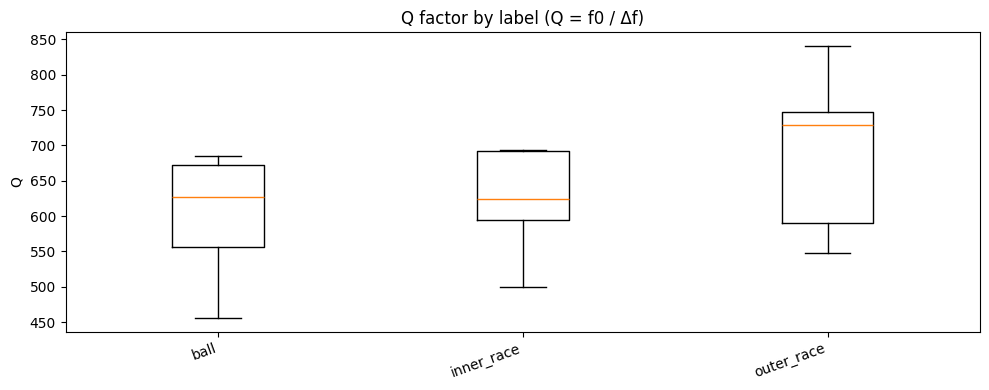

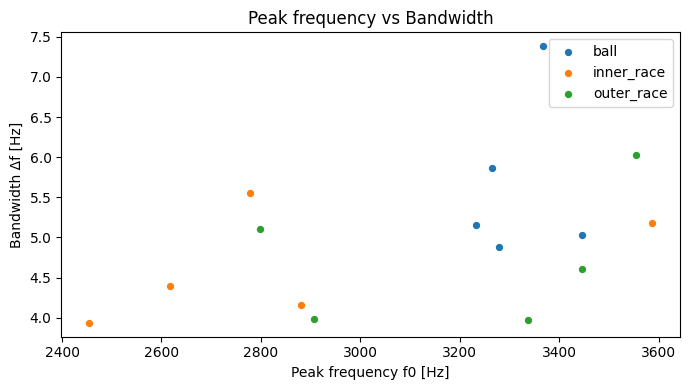

In [10]:
def boxplot_by_label_df(df: pd.DataFrame, col: str, title: str, ylabel: str, out_path: Path):
    labels = sorted(df["label"].unique())
    groups = [df.loc[df["label"] == lab, col].values for lab in labels]

    plt.figure(figsize=(10, 4))
    plt.boxplot(groups, labels=labels, showfliers=False)
    plt.xticks(rotation=20, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()
    plt.close()

boxplot_by_label_df(
    df, "bandwidth",
    title="Bandwidth Δf distribution by label (-3 dB / half-power)",
    ylabel="Bandwidth Δf [Hz]",
    out_path=OUT_DIR / "bandwidth_boxplot_by_label.png"
)

boxplot_by_label_df(
    df, "zeta_est",
    title="Estimated damping ratio ζ by label (ζ ≈ Δf / (2 f0))",
    ylabel="ζ (estimated)",
    out_path=OUT_DIR / "zeta_boxplot_by_label.png"
)

boxplot_by_label_df(
    df, "Q",
    title="Q factor by label (Q = f0 / Δf)",
    ylabel="Q",
    out_path=OUT_DIR / "Q_boxplot_by_label.png"
)

plt.figure(figsize=(7, 4))
for lab in sorted(df["label"].unique()):
    sub = df[df["label"] == lab]
    plt.scatter(sub["f0"], sub["bandwidth"], s=18, label=lab)
plt.xlabel("Peak frequency f0 [Hz]")
plt.ylabel("Bandwidth Δf [Hz]")
plt.title("Peak frequency vs Bandwidth")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "f0_vs_bandwidth_scatter.png", dpi=150)
plt.show()
plt.close()